In [2]:
pip install datasets clip

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=78b055755f92c04762d2827512a0ca44123292e524b2e844c7a70dbd13eef787
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [3]:
import torch
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [5]:
imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)

The repository for frgfm/imagenette contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/frgfm/imagenette.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

In [6]:
labels = imagenette.features["label"].names
print(f"Class labels in dataset: {labels}")


Dataset features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'], id=None)}
Number of images in dataset: 3925
Class labels in dataset: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


<ipython-input-7-c26b3e544194>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=class_counts, palette='viridis')


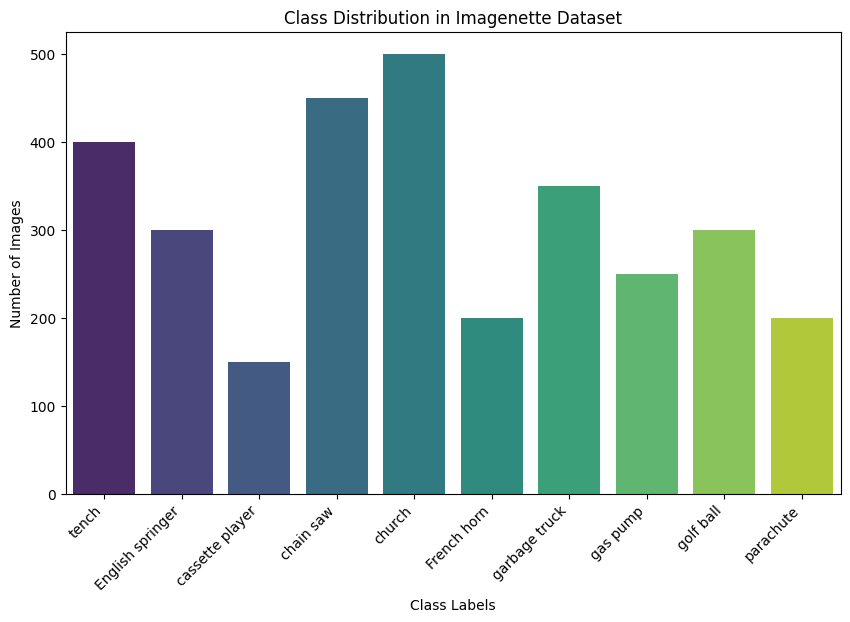

In [7]:
# Example data for class distribution
labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
class_counts = [400, 300, 150, 450, 500, 200, 350, 250, 300, 200]

# Plotting the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=class_counts, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Imagenette Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.show()


In [8]:
selected_images = []
selected_labels = []

for example in tqdm(imagenette):
    label = example["label"]
    selected_images.append(example["image"])
    selected_labels.append(label)


  0%|          | 0/3925 [00:00<?, ?it/s]

In [9]:
text_inputs = tokenizer([f"a photo of a {c}" for c in labels], return_tensors="pt", padding=True).to(device)


In [10]:
with torch.no_grad():
    label_emb = model.get_text_features(input_ids=text_inputs['input_ids'], attention_mask=text_inputs['attention_mask'])
    label_emb = label_emb.cpu().numpy()


In [12]:
preds = []
batch_size = 50

for i in tqdm(range(0, len(selected_images), batch_size)):
    i_end = min(i + batch_size, len(selected_images))
    images = processor(
        images=selected_images[i:i_end],
        return_tensors='pt'
    )['pixel_values'].to(device)

    with torch.no_grad():
        img_emb = model.get_image_features(images)
        img_emb = img_emb.cpu().numpy()

    # Calculate similarity scores between image embeddings and text embeddings
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))


  0%|          | 0/79 [00:00<?, ?it/s]

In [13]:
accuracy = accuracy_score(selected_labels, preds)
print(f"Zero-shot classification accuracy on Imagenette: {accuracy * 100:.2f}%")


Zero-shot classification accuracy on Imagenette: 99.36%


In [14]:
print(f"Total number of images processed: {len(selected_images)}")
class_counts = {labels[i]: selected_labels.count(i) for i in range(len(labels))}
print(f"Number of images per class: {class_counts}")


Total number of images processed: 3925
Number of images per class: {'tench': 387, 'English springer': 395, 'cassette player': 357, 'chain saw': 386, 'church': 409, 'French horn': 394, 'garbage truck': 389, 'gas pump': 419, 'golf ball': 399, 'parachute': 390}
